<h1> Script predicción</h1> 
<h2> The Backpropagation Boyz </h2>

# Librerias y funciones  

In [1]:
import numpy as np 
import os 
import tensorflow as tf
import sklearn 
import matplotlib.pyplot as plt
import pandas as pd
from scipy import ndimage
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#clustering
from scipy.cluster.hierarchy import complete,single, fcluster,dendrogram
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist
from sklearn.metrics import pairwise_distances
import datetime
import seaborn as sns




#esta funcion coge series como input y las secciona, dando n puntos iniciales (feature) y los m siguientes (labels)

def window(data_big,size_input,size_output=None,data_aux=None):
  if size_output is not None:
    #esto para implementar que se devuelvan ventanas mas grandes
    features=[]
    labels=[]
    #if data_aux is not None:
      #data_aux=data_aux.T
    for i in range(0,data_big.shape[0]):
      data=data_big[i]
      for j in range(data_big.shape[1] - size_input -size_output):
        if data_aux is not None:
          data_aux_slice=data_aux[:,j:(j+size_input)]
          features.append(np.vstack([data[j:(j+size_input)][np.newaxis,...],data_aux_slice]))#[...,np.newaxis]
        else:
          features.append(data[j:(j+size_input)])
        labels.append(data[(j+size_input):(j+size_input+size_output)])
  else:
    features=[]
    labels=[]
    for i in range(0,data_big.shape[0]):
      data=data_big[i]
      for j in range(data_big.shape[1] - size_input -1):
        if data_aux is not None:
          data_aux_slice=data_aux[:,j:(j+size_input)]
          features.append(np.vstack([data[j:(j+size_input)][np.newaxis,...],data_aux_slice]))#[...,np.newaxis]

        else:
          features.append(data[j:(j+size_input)])
        labels.append(data[j+size_input+1])

  #tenemos que poner el canal al final
  features=np.array(features)
  if data_aux is not None:
    features=np.swapaxes(features,1,2)

  return features,np.array(labels)  



#funcion que coge una serie temporal, un modelo y va predicciendo todo lo que puede 
#si toma inputs de 20 y devuelve 7, va prediciendo asi la serie temporal (de 7 en en 7 conociendo los 20 anteriores)
def pred_model2(model,ts,window):
  input_size=model.input_shape[1]
  leng=ts.shape[0]
  preds=[]
  for i in range(input_size,leng-window,window):
    preds.append(model.predict(ts[(i-input_size):i][np.newaxis,...])[0])
  return np.array(preds)

  
def pred_model3(model,ts,window,extras):
  input_size=model.input_shape[1]
  leng=ts.shape[0]
  preds=[]
  x=np.hstack([ts[...,np.newaxis],np.swapaxes(extras,0,1)])
  for i in range(input_size,leng-window,window):
    x_aux=x[(i-input_size):i,:]
    preds.append(model.predict(x_aux[np.newaxis,...])[0])
  return np.array(preds)

# Carga y preprocesado de datos

Comenzamos ordenando las muestras del fichero.

In [2]:
!sort Modelar_UH2022.txt > Modelar_UH2022_sorted.txt

In [3]:
!head Modelar_UH2022_sorted.txt

0|2019-02-01 00:39:36|331710|0|0|0
0|2019-02-01 01:39:36|331710|0|0|0
0|2019-02-01 02:39:35|331710|0|0|0
0|2019-02-01 03:39:35|331710|0|0|0
0|2019-02-01 04:39:35|331710|0|0|0
0|2019-02-01 05:39:35|331710|0|0|0
0|2019-02-01 06:39:35|331710|0|0|0
0|2019-02-01 07:39:35|331729|0|19|0
0|2019-02-01 08:39:35|331765|0|36|0
0|2019-02-01 09:39:35|331765|0|0|0


La cabecera se ha quedado al final, vamos a moverla al principio.

In [4]:
!sed '1h;1d;$!H;$!d;G' Modelar_UH2022_sorted.txt > tmp.txt; mv tmp.txt Modelar_UH2022_sorted.txt

In [5]:
!head Modelar_UH2022_sorted.txt

ID|SAMPLETIME|READINGINTEGER|READINGTHOUSANDTH|DELTAINTEGER|DELTATHOUSANDTH
0|2019-02-01 00:39:36|331710|0|0|0
0|2019-02-01 01:39:36|331710|0|0|0
0|2019-02-01 02:39:35|331710|0|0|0
0|2019-02-01 03:39:35|331710|0|0|0
0|2019-02-01 04:39:35|331710|0|0|0
0|2019-02-01 05:39:35|331710|0|0|0
0|2019-02-01 06:39:35|331710|0|0|0
0|2019-02-01 07:39:35|331729|0|19|0
0|2019-02-01 08:39:35|331765|0|36|0


No nos interesan los datos de cada hora, vamos a agregarlos para tener la información diaria de cada deposito. Asimismo, tendremos en cuenta un solo valor sin decimales.

In [6]:
!rm Modelar_UH2022_agg.txt

In [7]:
file1 = open('Modelar_UH2022_sorted.txt', 'r')
file2 = open('Modelar_UH2022_agg.txt', 'a')
iden_pre = ""
curr_delta = 0
curr_reading = 0

for i, line in enumerate(file1.readlines()):
    if i != 0:
        iden, content  = line.split()
        content = content.split('|')

        if '' in content: content = ['0' if c == '' else c for c in content]

        if iden != iden_pre and i!= 1:

            file2.write(iden_pre+'|'+ str(curr_reading)+'|'+str(curr_delta)+'\n')
            curr_delta = 0

            
        curr_reading = int(content[1])*100 + int(content[2])*(10**(2-len(content[2])))

        curr_delta += int(content[3])*100 + int(content[4])*(10**(2-len(content[2])))

        iden_pre = iden

    else:
        file2.write('ID|SAMPLETIME|READING|DELTA\n')

file1.close()
file2.close()

In [8]:
!rm Modelar_UH2022_sorted.txt

In [25]:
ds = pd.read_csv("Modelar_UH2022_agg.txt", sep='|')

In [26]:
ds.head()

,ID,SAMPLETIME,READING,DELTA
0,0,2019-02-01,33195300,24300
1,0,2019-02-02,33218900,23600
2,0,2019-02-03,33252400,33500
3,0,2019-02-04,33277600,25200
4,0,2019-02-05,33299600,22000


In [31]:
df = pd.DataFrame()
dates = sorted(ds['SAMPLETIME'].unique())
df['DATE'] = dates

In [32]:
for i, idd in enumerate(sorted(ds['ID'].unique())):
    filtered = ds[ds['ID'] == idd]
    colname = 'DELTA_ID' + str(i+1)
    df[colname] = df.merge(filtered, how='left', left_on='DATE', right_on='SAMPLETIME')['DELTA']

In [42]:
df.to_csv('consumo_aggbyday_filledzeros_samelength.csv')

In [45]:
datos = pd.read_csv('consumo_aggbyday_filledzeros_samelength.csv')
datos = datos.iloc[:, 1:]
print(datos.head())

         DATE  DELTA_ID1  DELTA_ID2  DELTA_ID3  DELTA_ID4  DELTA_ID5  \
0  2019-02-01      24300        800          0      49200      25260   
1  2019-02-02      23600       4700          0      38100      24171   
2  2019-02-03      33500        600          0      31300      26641   
3  2019-02-04      25200       1200          0      36200      41200   
4  2019-02-05      22000       4400          0      38000      26900   

   DELTA_ID6  DELTA_ID7  DELTA_ID8  DELTA_ID9  ...  DELTA_ID2738  \
0      44496       8000       4500        400  ...           NaN   
1          0       1100       3600          0  ...           NaN   
2          0       6900      42600          0  ...           NaN   
3          0      27196      43300        700  ...           NaN   
4          0      23092       6300          0  ...           NaN   

   DELTA_ID2739  DELTA_ID2740  DELTA_ID2741  DELTA_ID2742  DELTA_ID2743  \
0           NaN           NaN           NaN           NaN           NaN   
1       

In [46]:
lectura = datos.iloc[:,1:].fillna(0,inplace=False).to_numpy().T

#vamos a suavizar todo y a escalarlo
data_filtered = ndimage.gaussian_filter(lectura,[0,3],0)
scaler=MinMaxScaler()
data_pre=scaler.fit_transform(data_filtered.T).T

# Clustering jerarquico

Antes de hacer ningún clustering, vamos a hacer un clustering con aquellos condadores que estén desconectados, todos aquellos que lleven:  

* Los últimos 7 días sin lecturas.  
* Si tuvieron una en los últimos 7 dias, pero no en los 7 anteriores, también entran en el cluster. 

Todos estos obtendrán la categoría de 0 (0 valor para las predicciones).

Y despues ya realizamos con el resto el clustering. 

In [ ]:
#para simplificar todo, lo que hacemos es que TODA la serie la ponemos a 0 para los que 
#cumplan con las condiciones que hemos dicho

data_pre_aux=[]
for j,i in enumerate(data_pre):
  if np.all(i[-7:]<0.001):
    data_pre[j,:]=np.zeros_like(data_pre[j])
    #lo cambiamos tambien en los datos para que afecte el entrenamiento
    lectura[j,:]=np.zeros_like(lectura[j])
  elif np.sum(i[-7:]>0.001)<=3:
    if np.all(i[-14:-7]<0.001):
      data_pre[j,:]=np.zeros_like(data_pre[j])
      #lo cambiamos tambien en los datos para que afecte el entrenamiento
      lectura[j,:]=np.zeros_like(lectura[j])


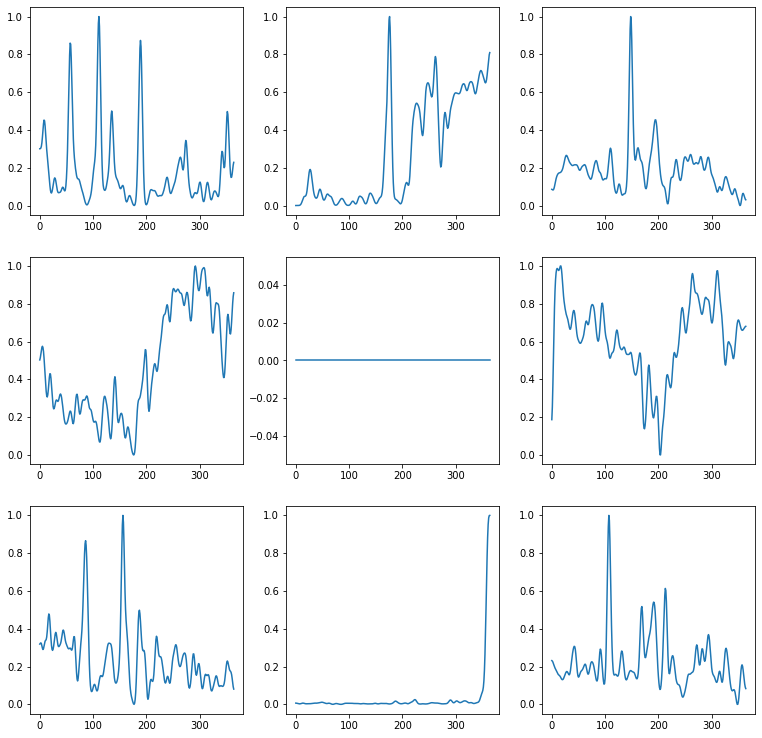

In [ ]:
#imagenes suavizadas
plt.figure(figsize=(13,13))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.plot(data_pre[i])

/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:360: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


(77, 365)
(1125, 365)
(685, 365)
(860, 365)


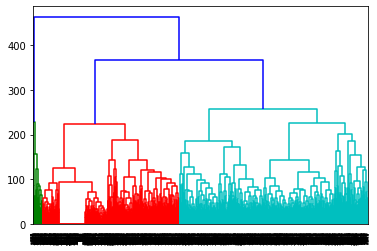

In [ ]:
#sacamos las distancias y hacemos el clustering
d=pairwise_distances(data_pre)
a=complete(d)
dendrogram(a);
ind=fcluster(a,4,"maxclust")
#sacamos los subgrupos, escogemos solo 5
datos_g=[]
for i in range(1,5):
  datos_g.append(data_pre[ind==i])
  print(datos_g[i-1].shape)


**Nota:** Primero haremos todo el proceso de entrenamiendo para uno solo de los clusters, y después se realizará el proceso para todos (en bucle).

# Entrenamiento

En esta prueba se realiza con una ventada input, de 20, **pero en el modelo final, esta ventana se ampliará hasta 40**, para así dotar al modelo de mayor perspectiva.

In [ ]:
feat,labs=window(datos_g[1],20,7)
print(labs.shape,feat.shape)
x_train,x_test,y_train,y_test= train_test_split(feat,labs,test_size=0.2)


(358956, 7) (358956, 20)


In [ ]:
#la creamos
input=tf.keras.layers.Input(shape=[20,1])
x=tf.keras.layers.LSTM(30,return_sequences=True)(input)
x=tf.keras.layers.LSTM(60,return_sequences=False)(x)
x=tf.keras.layers.Dense(50,activation="relu",kernel_regularizer="l2")(x)
x=tf.keras.layers.Dense(7,activation="sigmoid",kernel_regularizer="l2")(x)

model=tf.keras.Model(input,x)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 60)                21840     
                                                                 
 dense (Dense)               (None, 50)                3050      
                                                                 
 dense_1 (Dense)             (None, 7)                 357       
                                                                 
Total params: 29,087
Trainable params: 29,087
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#la entrenamos
model.compile(optimizer="adam",loss="mse")
hist=model.fit(x_train,y_train,epochs=20,batch_size=128,validation_split=0.2)

Epoch 1/20
1795/1795 [==============================] - 35s 15ms/step - loss: 0.0566 - val_loss: 0.0240
Epoch 2/20
1795/1795 [==============================] - 26s 15ms/step - loss: 0.0222 - val_loss: 0.0207
Epoch 3/20
1795/1795 [==============================] - 26s 15ms/step - loss: 0.0202 - val_loss: 0.0194
Epoch 4/20
1795/1795 [==============================] - 26s 15ms/step - loss: 0.0191 - val_loss: 0.0187
Epoch 5/20
1795/1795 [==============================] - 27s 15ms/step - loss: 0.0186 - val_loss: 0.0183
Epoch 6/20
1795/1795 [==============================] - 27s 15ms/step - loss: 0.0182 - val_loss: 0.0181
Epoch 7/20
1795/1795 [==============================] - 29s 16ms/step - loss: 0.0180 - val_loss: 0.0180
Epoch 8/20
1795/1795 [==============================] - 33s 18ms/step - loss: 0.0178 - val_loss: 0.0177
Epoch 9/20
1795/1795 [==============================] - 34s 19ms/step - loss: 0.0176 - val_loss: 0.0178
Epoch 10/20
1795/1795 [==============================] - 31s 17m

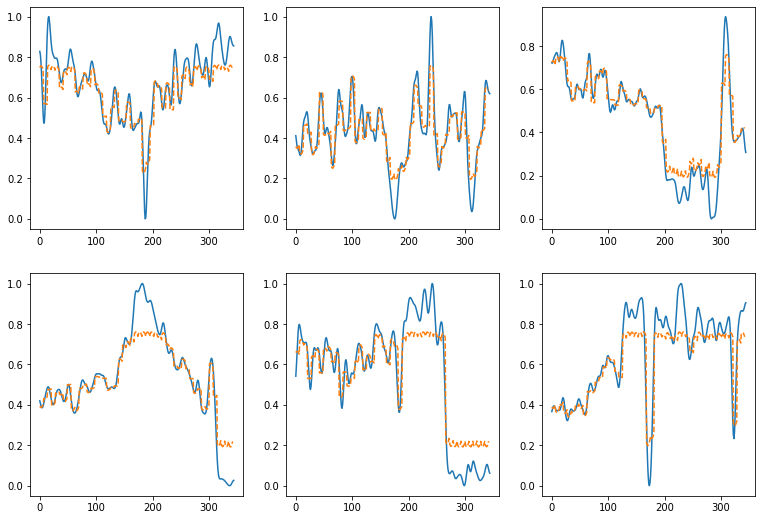

In [ ]:
#veamos los resultados (predecimos de 7 en 7)
plt.figure(figsize=(13,9))
for i,m in enumerate([23,56,76,43,12,65]):
  plt.subplot(2,3,i+1)
  a=pred_model2(model,datos_g[1][m],7)
  a.shape
  a=a.flatten()
  plt.plot(datos_g[1][m][20:])
  plt.plot(a,"--")

#### Carga datos múltiples canales

In [ ]:
#los cargamos 
aem=pd.read_csv("temperaturas_aemet.txt")
aem2=aem.loc[aem["observatorio"]=="ALICANTE/ALACANT"]
aem2.head()

,ID,dia,tavg,tmin,tmax,insolacion,precipitacion,pmax,pmin,observatorio
0,0,2019-02-01,"15,4","10,6","20,2","5,1","0,6",-999,-999,ALICANTE/ALACANT
1,1,2019-02-02,"12,2","9,1","15,4","7,2","0,0",-999,-999,ALICANTE/ALACANT
2,2,2019-02-03,"10,2","5,9","14,6","9,8","0,0",-999,-999,ALICANTE/ALACANT
3,3,2019-02-04,"9,6","3,2","15,9","9,9","0,0",-999,-999,ALICANTE/ALACANT
4,4,2019-02-05,"11,3","3,4","19,2","10,1","0,0",-999,-999,ALICANTE/ALACANT


In [ ]:
#mezcla de los datos
merged=pd.merge(datos,aem2.filter(["dia","tavg","insolacion","precipitacion"]),how="left",left_on="DATE",right_on="dia")
print(merged.shape)
merged.drop(columns=["dia"],inplace=True)
merged.loc[:,"tavg"]=merged.loc[:,"tavg"].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
merged.loc[:,"insolacion"]=merged.loc[:,"insolacion"].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
merged.loc[merged.precipitacion=="Ip","precipitacion"]=0 #esto no se porque estaba así
merged.loc[:,"precipitacion"]=merged.loc[:,"precipitacion"].astype(str).apply(lambda x: x.replace(",",".")).astype(float)

merged.head()


(365, 2752)


,DATE,DELTA_ID1,DELTA_ID2,DELTA_ID3,DELTA_ID4,DELTA_ID5,DELTA_ID6,DELTA_ID7,DELTA_ID8,DELTA_ID9,...,DELTA_ID2741,DELTA_ID2742,DELTA_ID2743,DELTA_ID2744,DELTA_ID2745,DELTA_ID2746,DELTA_ID2747,tavg,insolacion,precipitacion
0,2019-02-01,800,0,49200,25260,44496,8000,4500,400,10900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.4,5.1,0.6
1,2019-02-02,4700,0,38100,24171,0,1100,3600,0,30500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2,7.2,0.0
2,2019-02-03,600,0,31300,26641,0,6900,42600,0,20500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.2,9.8,0.0
3,2019-02-04,1200,0,36200,41200,0,27196,43300,700,28700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,9.9,0.0
4,2019-02-05,4400,0,38000,26900,0,23092,6300,0,15000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.3,10.1,0.0


In [ ]:
#eliminar nans y filtrar
merged2=merged.iloc[:,1:].fillna(0,inplace=False).to_numpy().T
merged2=ndimage.gaussian_filter(merged2,[0,1.5],0)
merged2.shape

(2750, 365)

In [ ]:
#normalizamos
scal=MinMaxScaler()
merged_norm=scal.fit_transform(merged2.T)
print(merged_norm.shape)
consumo,extras=merged_norm[:,:-3].T,merged_norm[:,-3:].T
print(extras.shape,consumo.shape)

(365, 2750)
(3, 365) (2747, 365)


In [ ]:
#esto es repetir lo del clustering
consumo_g=[]
for i in range(1,5):
  consumo_g.append(consumo[ind==i])
  print(consumo_g[i-1].shape)

(196, 365)
(1062, 365)
(782, 365)
(707, 365)


In [ ]:
#separamos los datos en train y test
consumo_train,consumo_test= train_test_split(consumo_g[1],test_size=0.2)

inputs_train,outputs_train=window(consumo_train,20,7,extras)
print(inputs_train.shape,outputs_train.shape) #(365-20-7)*2747

x_train,x_val,y_train,y_val= train_test_split(inputs_train,outputs_train,test_size=0.2)
print(x_train.shape,x_val.shape,y_train.shape,y_val.shape)

#para testear
inputs_test,outputs_test=window(consumo_test,20,7,extras)


(286962, 20, 4) (286962, 7)
(229569, 20, 4) (57393, 20, 4) (229569, 7) (57393, 7)


### Modelo con múltiples canales

In [ ]:

#creamos NN con LSTMs
input=tf.keras.layers.Input(shape=[20,4])
x=tf.keras.layers.LSTM(60,return_sequences=True)(input)
x=tf.keras.layers.LSTM(20,return_sequences=False)(x)
x=tf.keras.layers.Dense(100,activation="relu")(x)
x=tf.keras.layers.Dense(50,activation="relu",kernel_regularizer="l2")(x)
x=tf.keras.layers.Dense(7,activation="relu",kernel_regularizer="l2")(x)

model=tf.keras.Model(input,x)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 20, 4)]           0         
                                                                 
 lstm_4 (LSTM)               (None, 20, 60)            15600     
                                                                 
 lstm_5 (LSTM)               (None, 20)                6480      
                                                                 
 dense_5 (Dense)             (None, 100)               2100      
                                                                 
 dense_6 (Dense)             (None, 50)                5050      
                                                                 
 dense_7 (Dense)             (None, 7)                 357       
                                                                 
Total params: 29,587
Trainable params: 29,587
Non-trainable

In [ ]:
#la entrenamos
model.compile(optimizer="adam",loss="mse")
hist=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=20,batch_size=128,validation_split=0.2)

Epoch 1/20
1435/1435 [==============================] - 27s 15ms/step - loss: 0.1019 - val_loss: 0.0241
Epoch 2/20
1435/1435 [==============================] - 26s 18ms/step - loss: 0.0201 - val_loss: 0.0187
Epoch 3/20
1435/1435 [==============================] - 21s 15ms/step - loss: 0.0177 - val_loss: 0.0172
Epoch 4/20
1435/1435 [==============================] - 21s 15ms/step - loss: 0.0168 - val_loss: 0.0166
Epoch 5/20
1435/1435 [==============================] - 21s 15ms/step - loss: 0.0162 - val_loss: 0.0161
Epoch 6/20
1435/1435 [==============================] - 21s 15ms/step - loss: 0.0159 - val_loss: 0.0160
Epoch 7/20
1435/1435 [==============================] - 21s 15ms/step - loss: 0.0156 - val_loss: 0.0156
Epoch 8/20
1435/1435 [==============================] - 21s 15ms/step - loss: 0.0154 - val_loss: 0.0154
Epoch 9/20
1435/1435 [==============================] - 21s 15ms/step - loss: 0.0153 - val_loss: 0.0156
Epoch 10/20
1435/1435 [==============================] - 21s 15m

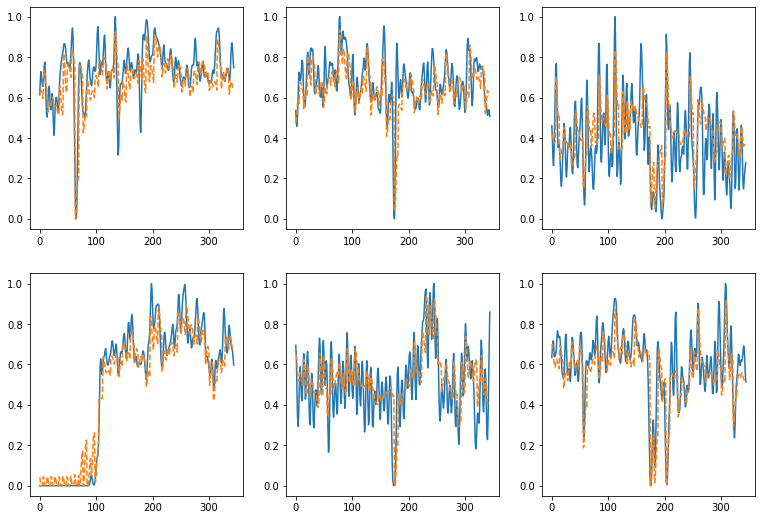

In [ ]:
#veamos los resultados
plt.figure(figsize=(13,9))
for i,m in enumerate([23,4,76,2,1,65]):
  plt.subplot(2,3,i+1)
  a=pred_model3(model,consumo_test[m],7,extras)
  a.shape
  a=a.flatten()
  plt.plot(consumo_test[m][20:])
  plt.plot(a,"--")

# Construcción final de los modelos:

 Tenemos que construir el modelo para todos los clusters que hemos sacado.  
 
**Es en esta parte donde se hace el clústering y entrenamiento final de los modelos de predicción**.

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:364: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


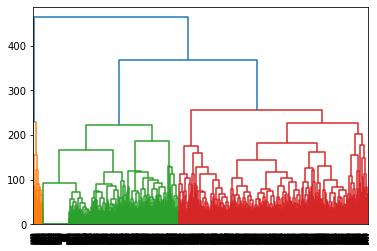

In [50]:
#ESTO CARGA DE DATOS

#cargamos los datos y los extra 
datos = pd.read_csv('consumo_aggbyday_filledzeros_samelength.csv')
datos = datos.iloc[:, 1:]
aem=pd.read_csv("temperaturas_aemet.txt")
aem2=aem.loc[aem["observatorio"]=="ALICANTE/ALACANT"]




#los unimos a los que ya tenemos
merged=pd.merge(datos,aem2.filter(["dia","tavg","insolacion","precipitacion"]),how="left",left_on="DATE",right_on="dia")
merged.drop(columns=["dia"],inplace=True)
merged.loc[:,"tavg"]=merged.loc[:,"tavg"].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
merged.loc[:,"insolacion"]=merged.loc[:,"insolacion"].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
merged.loc[merged.precipitacion=="Ip","precipitacion"]=0 #esto no se porque estaba así
merged.loc[:,"precipitacion"]=merged.loc[:,"precipitacion"].astype(str).apply(lambda x: x.replace(",",".")).astype(float)
merged2=merged.iloc[:,1:].fillna(0,inplace=False).to_numpy().T
merged2=ndimage.gaussian_filter(merged2,[0,1.5],0)
scal=MinMaxScaler()
merged_norm=scal.fit_transform(merged2.T)
consumo,extras=merged_norm[:,:-3].T,merged_norm[:,-3:].T


#ESTO SOLO CLUSTERING

#repetimos la clusterizacion que teníamos en primer luegar (para tenerlo todo junto)
lectura = datos.iloc[:,1:].fillna(0,inplace=False).to_numpy().T
#vamos a suavizar todo y a escalarlo
data_filtered = ndimage.gaussian_filter(lectura,[0,3],0)
scaler=MinMaxScaler()
data_pre=scaler.fit_transform(data_filtered.T).T
for j,i in enumerate(data_pre):
  if np.all(i[-7:]<0.001):
    data_pre[j,:]=np.zeros_like(data_pre[j])
    #lo cambiamos tambien en los datos para que afecte el entrenamiento
    lectura[j,:]=np.zeros_like(lectura[j])
    consumo[j,:]=np.zeros_like(consumo[j])
  elif np.sum(i[-7:]>0.001)<=3:
    if np.all(i[-14:-7]<0.001):
      data_pre[j,:]=np.zeros_like(data_pre[j])
      #lo cambiamos tambien en los datos para que afecte el entrenamiento
      lectura[j,:]=np.zeros_like(lectura[j])
      consumo[j,:]=np.zeros_like(consumo[j])


d=pairwise_distances(data_pre)
a=complete(d)
dendrogram(a);
ind=fcluster(a,4,"maxclust")



In [51]:
#esta linea se añade para comprobar que los tamaño y orden de los clusters es el correcto
np.unique(ind,return_counts=True)#(array([1, 2, 3, 4], dtype=int32), array([  77, 1125,  685,  860]))


(array([1, 2, 3, 4], dtype=int32), array([  77, 1115,  425, 1130]))

In [7]:
#entrenamos los modelos en bucle, con los datos de cada cluster
models= []
for i in range(1,5):

  #sacamos los datos indicados
  x_cluster=consumo[ind==i]

  #creamos el set de entrenamiento
  #separamos los datos en train y test
  #pero para el entrenamiento final esto no lo hacemos
  #consumo_train,consumo_test= train_test_split(consumo_g[1],test_size=0.2)
  #x_train,x_val,y_train,y_val= train_test_split(inputs_train,outputs_train,test_size=0.2)
  #inputs_test,outputs_test=window(consumo_test,20,7,extras)

  inputs_train,outputs_train=window(x_cluster,40,7,extras)

  #creamos el modelo
  input=tf.keras.layers.Input(shape=[40,4])
  x=tf.keras.layers.LSTM(30,return_sequences=True)(input)
  x=tf.keras.layers.LSTM(20,return_sequences=False)(x)
  x=tf.keras.layers.Dense(100,activation="relu")(x)
  x=tf.keras.layers.Dense(50,activation="relu",kernel_regularizer="l2")(x)
  x=tf.keras.layers.Dense(7,activation="sigmoid",kernel_regularizer="l2")(x)

  model=tf.keras.Model(input,x)

  #entrenamos el modelo
  model.compile(optimizer="adam",loss="mse")
  model.fit(inputs_train,outputs_train,epochs=20,batch_size=128,validation_split=0.1)

  #esto es para hacer una copia profunda de los datos del modelo
  model_copy= tf.keras.models.clone_model(model)
  model_copy.build((None,40,4)) # replace 10 with number of variables in input layer
  model_copy.compile(optimizer='adam', loss='mse')
  model_copy.set_weights(model.get_weights())

  models.append(model_copy)


Epoch 1/20
173/173 [==============================] - 12s 25ms/step - loss: 0.3259 - val_loss: 0.1054
Epoch 2/20
173/173 [==============================] - 3s 20ms/step - loss: 0.0539 - val_loss: 0.0491
Epoch 3/20
173/173 [==============================] - 3s 20ms/step - loss: 0.0331 - val_loss: 0.0434
Epoch 4/20
173/173 [==============================] - 3s 20ms/step - loss: 0.0294 - val_loss: 0.0389
Epoch 5/20
173/173 [==============================] - 3s 20ms/step - loss: 0.0273 - val_loss: 0.0366
Epoch 6/20
173/173 [==============================] - 3s 20ms/step - loss: 0.0258 - val_loss: 0.0342
Epoch 7/20
173/173 [==============================] - 3s 20ms/step - loss: 0.0247 - val_loss: 0.0326
Epoch 8/20
173/173 [==============================] - 4s 21ms/step - loss: 0.0236 - val_loss: 0.0312
Epoch 9/20
173/173 [==============================] - 4s 22ms/step - loss: 0.0229 - val_loss: 0.0308
Epoch 10/20
173/173 [==============================] - 4s 22ms/step - loss: 0.0223 - val_l

In [12]:
#guardamos los modelos para futuro uso
for j,i in enumerate(models):
  i.save(f"modelos/MASTER_model_cluster{j+1}.h5")

In [60]:
#cargamos los modelos
models = []
for j in range(1,5):
  models.append(tf.keras.models.load_model(f"modelos/MASTER_model_cluster{j}.h5"))

2022-03-21 11:15:40.251496: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Nos falta hacer la predicción de los datos que nos interesan, y desescalarlos, para que vuelvan a tomar valores en el rango que tenían inicialmente.

In [61]:
#todo esto lo implementamos en una funcion que recibe el modelo y los datos
def predict_one(model,data,extra):
  #cogemos unos valores y los pasamos al rango 0, 1
  scal=MinMaxScaler()
  data=scal.fit_transform(data.reshape(-1, 1))[:,0]
  #a los datos les aplicamos un filtro gausiano para suavizarlo
  data=ndimage.gaussian_filter(data,1.5,0)
  x=np.vstack([data,extra])
  x=np.swapaxes(x,0,1)
  y_pred=model.predict(x[-40:,:][np.newaxis,...])

  y_pred=scal.inverse_transform(y_pred.reshape(-1, 1))
  return y_pred[:,0]

#una función que recorra todos los contadores pasandole los datos, los indices de clustering,
#y los modelos para cada clustering, y devuelva la prediccion para 1 semana
def predict_all(models,data,indices,extra):
  pred=[]
  for i,dat in enumerate(data):
    pred.append(predict_one(models[indices[i]-1],dat,extra))
  return np.array(pred)

In [62]:
#prediccion de la primera semana
a=predict_all(models,lectura,ind,extras)

(2747, 7)

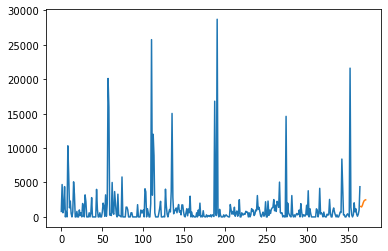

In [63]:
#ejemplo de predicción
plt.plot(lectura[1])
plt.plot(range(365,365+7),a[1])
a.shape

In [64]:
#guardamos la prediccion de la primera semana
np.save("MASTER_prediccion_1semana.npy",a)
#a=np.load("/content/drive/MyDrive/MasterCD/hackatlon/prediccion_1semana.npy")

In [65]:
#ahora juntamos esto a lo anterior y hacemos lo mismo
#para extras asumimos que son los mismos valos que la primera semana
new_extras=np.concatenate((extras,extras[:,-7:]),1)

new_lectura=np.concatenate((lectura,a),1)

#predicción segunda semana
b=predict_all(models,new_lectura,ind,new_extras)
#la guardamos
np.save("MASTER_prediccion_2semana.npy",b)

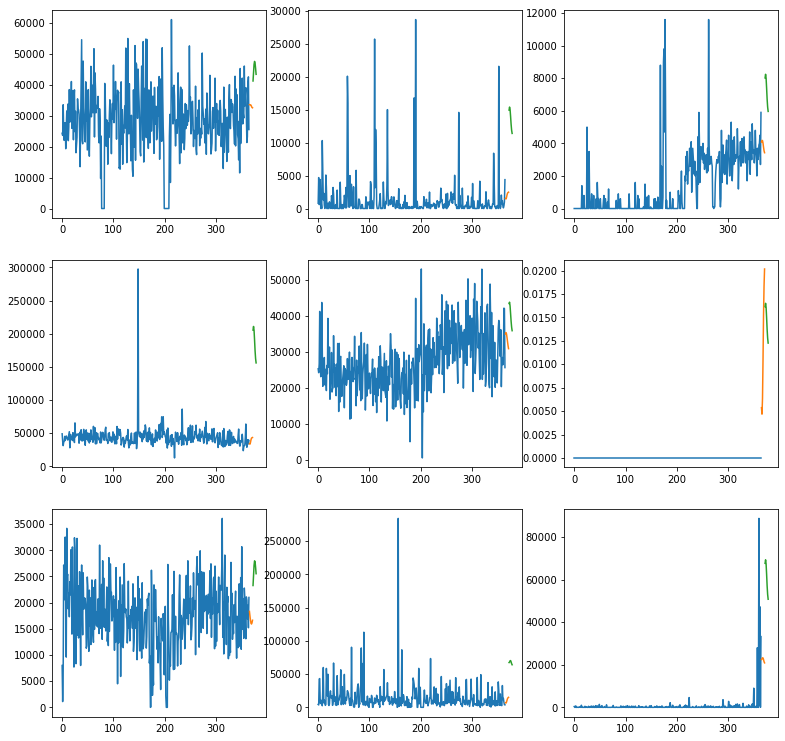

In [66]:
#ejemplos de las predicciones hechas
plt.figure(figsize=(13,13))
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.plot(lectura[i])
  plt.plot(range(365,365+7),a[i])
  plt.plot(range(365+7,365+7+7),b[i])

In [74]:
#creamos el archivo final con las predicciones
final=pd.DataFrame(a,columns=["Dia_1","Dia_2","Dia_3","Dia_4","Dia_5","Dia_6","Dia_7"])#,"Semana_1"])#,"Semana_2"])

#funcion que elimina predicciones ruidosas(las manda a 0) y redondea a 2 decimales
def to_cero(x):
    if x<10:
        x=0
    return round(x,2)


final=final.applymap(to_cero)
final.index.name = 'ID'
final["Semana_1"]=np.sum(final,axis=1)
final_b=pd.DataFrame(b,columns=["Dia_1","Dia_2","Dia_3","Dia_4","Dia_5","Dia_6","Dia_7"])#,"Semana_1"])#,"Semana_2"])
final_b=final_b.applymap(to_cero)
final["Semana_2"]=np.sum(final_b,axis=1)
final=final.applymap(to_cero)

final.head(8)

,Dia_1,Dia_2,Dia_3,Dia_4,Dia_5,Dia_6,Dia_7,Semana_1,Semana_2
ID,,,,,,,,,
0,33529.93,33449.04,33503.26,33346.91,32962.65,32621.80,32517.00,231930.59,314508.00
1,1514.86,1446.33,1667.71,2044.50,2325.53,2432.11,2482.78,13913.82,95498.59
2,4081.41,4182.69,4171.96,4008.95,3761.51,3545.64,3426.01,27178.17,50553.52
3,34194.40,33523.28,36056.37,39990.88,42563.14,43276.06,43568.09,273172.22,1304371.70
4,34955.89,35324.50,34979.38,33989.48,32834.39,31744.55,30858.12,234686.31,281608.20
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,18335.01,17477.16,16632.91,16088.54,15919.64,16153.19,16640.19,117246.64,183630.53
7,6920.37,6403.40,7821.57,10623.70,13148.02,14413.64,15082.59,74413.29,474326.96


In [72]:
#guardamos los resultados
final.to_csv("The Backpropagation Boyz.txt",sep="|",header=False)